In [1]:
cd ~/Workspace/compression-ml/

/home/navneedhmaudgalya/Workspace/compression-ml


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os 
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.manifold import TSNE

from cifar_models import *
from utils.dataset import *
from utils.image_utils import *
from cifar_models.vgg import *

device = "cuda" if torch.cuda.is_available() else "cpu"

plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 13

In [3]:
def pytorch_count_params(model):
  "count number trainable parameters in a pytorch model"
  total_params = sum(reduce( lambda a, b: a*b, x.size()) for x in model.parameters())
  return total_params

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

BATCH_SIZE = 128
EPOCHS = 35

In [6]:
bls_bpp = [0.2612, 0.408, 0.519, 0.702, 0.837, 0.952, 1.08, 1.21, 1.359, 1.48712]
bls_full_bpp = [0.572, 0.719, 0.830, 0.928, 1.02]
other_bpp = [0.2841, 0.4564, 0.5248, 0.6483, 0.7346, ]
jpeg_bpp = [0.3559, 0.484, 0.7054, 1.034, 1.50, 1.91, 2.74]
jpeq_quality = [1,5,10,20,40,60,80,100]
exp_results_folder = "exp_results/"

base_vgg11 = np.load(exp_results_folder + "base_vgg11.npz")

# jpeg80_vgg11 = np.load(exp_results_folder +"jpeg80_vgg11.npz")
# jpeg60_vgg11 = np.load(exp_results_folder +"jpeg60_vgg11.npz")
# jpeg40_vgg11 = np.load(exp_results_folder +"jpeg40_vgg11.npz")
# jpeg20_vgg11 = np.load(exp_results_folder +"jpeg20_vgg11.npz")
# jpeg10_vgg11 = np.load(exp_results_folder +"jpeg10_vgg11.npz")
# jpeg5_vgg11 = np.load(exp_results_folder +"jpeg5_vgg11.npz")
# jpeg1_vgg11 = np.load(exp_results_folder +"jpeg1_vgg11.npz")

bls33_vgg11 = np.load(exp_results_folder +"bls33_vgg11.npz")
bls24_vgg11 = np.load(exp_results_folder +"bls24_vgg11.npz")
bls17_vgg11 = np.load(exp_results_folder +"bls17_vgg11.npz")
bls12_vgg11 = np.load(exp_results_folder +"bls12_vgg11.npz")
bls9_vgg11 = np.load(exp_results_folder +"bls9_vgg11.npz")
bls7_vgg11 = np.load(exp_results_folder +"bls7_vgg11.npz")
bls5_vgg11 = np.load(exp_results_folder +"bls5_vgg11.npz")
bls3_vgg11 = np.load(exp_results_folder +"bls3_vgg11.npz")
bls1_vgg11 = np.load(exp_results_folder +"bls1_vgg11.npz")

jpeg_results = [jpeg1_vgg11, jpeg5_vgg11, jpeg10_vgg11, jpeg20_vgg11, jpeg40_vgg11, jpeg60_vgg11, jpeg80_vgg11]
bls_results = [bls1_vgg11, bls2_vgg11, bls3_vgg11, bls5_vgg11, bls7_vgg11, bls9_vgg11, bls12_vgg11, bls17_vgg11, bls24_vgg11, bls33_vgg11]

In [49]:
test_dset = CifarDataset(data_folder = "_sp", train = False, transform = transform)
test_loader = DataLoader(test_dset, batch_size = 128, shuffle = False)

net = VGG('VGG11').to(device)
net.load_state_dict(torch.load("saved_models/bls33_vgg11.pt"))
print(pytorch_count_params(net))

86282


In [50]:
def test(testloader):
    softmax_output = nn.Softmax()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    metrics = []
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)

            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        return correct/total, test_loss/(10000/BATCH_SIZE) 

test_acc, test_loss = test(test_loader)
print(test_acc)

0.2186


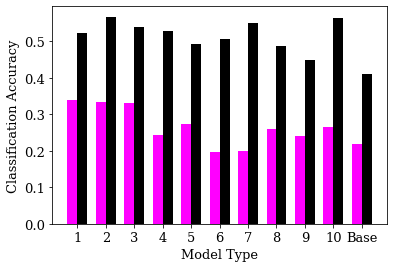

In [4]:
labels = list(range(11))
sp = np.array([0.3394, 0.3347, 0.3305, 0.2437, 0.272, 0.1961, 0.1997, 0.2601, 0.2411, 0.2641, 0.2186])
wn = np.array ([0.5221, 0.5669, 0.5398, 0.5281, 0.4935, 0.5072, 0.5487, 0.4879, 0.4488, 0.5624, 0.4095])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects2 = ax.bar(x - width/2, sp, width, label='Salt and Pepper', color = "magenta")
rects1 = ax.bar(x + width/2, wn, width, label='Gaussian', color = "black")
# rects3 = ax.bar(10 - width/2, 0.2186, width, color = "magenta")
# rects4 = ax.bar(10 + width/2, 0.4095, width, color = "black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Classification Accuracy')
ax.set_xlabel('Model Type')
ax.set_xticks(x)
ax.set_xticklabels(list(range(1,11)) + ["Base"])
plt.savefig("noise.png", dpi = 100)
# plt.bar(range(10), sp)
# # plt.bar(10, 0.4095)
# plt.bar(10, 0.2186)
# plt.title("Model Performance on Data with Gaussian Noise")
# plt.ylabel("Classification Accuracy")
# plt.xlabel("Model Type")

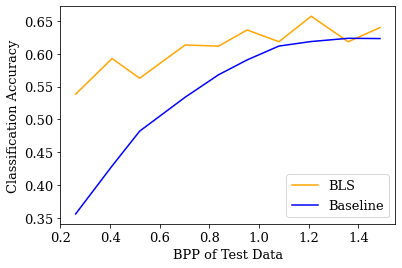

In [7]:
bls_baseline_test = [0.356, 0.4291, 0.4821, 0.5337, 0.568, 0.5906, 0.6117, 0.6186, 0.6235, 0.6231]
plt.plot(bls_bpp, [i['test_acc'][-1] for i in bls_results], label = "BLS", color = "orange")
# plt.plot(range(10), np.ones(10) * np.load("exp_results/base_vgg11.npz")['test_acc'].max())
plt.plot(bls_bpp, bls_baseline_test, label = "Baseline", color = "blue")
plt.ylabel("Classification Accuracy")
plt.xlabel("BPP of Test Data")
plt.legend(loc = 4)
plt.savefig("original_compressed.png", dpi = 100)

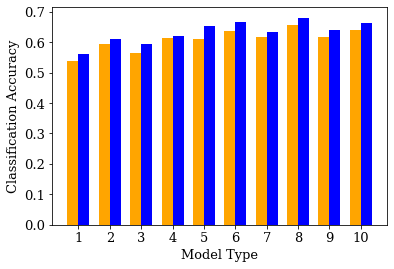

In [24]:
labels = list(range(10))
uncompress = np.array([0.562, 0.6103, 0.5925, 0.6196, 0.6523, 0.6671, 0.6349, 0.6802, 0.6397, 0.6626])
compress = np.array([i['test_acc'][-1] for i in bls_results])
# plt.plot(range(10), [i['test_acc'][-1] for i in bls_results], label = "compressed")
# plt.plot(range(10), np.ones(10) * np.load("exp_results/base_vgg11.npz")['test_acc'].max())
# plt.plot(bls_baseline_test, label = "uncompressed")


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects2 = ax.bar(x + width/2, uncompress, width, label='Uncompressed', color = "blue")
rects1 = ax.bar(x - width/2, compress, width, label='Compressed', color = "orange")
# rects3 = ax.bar(10 - width/2, 0.2186, width, color = "magenta")
# rects4 = ax.bar(10 + width/2, 0.4095, width, color = "black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Classification Accuracy')
ax.set_xlabel('Model Type')
ax.set_xticks(x)
ax.set_xticklabels(list(range(1,11)))
# plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1, framealpha = 1, title = "Test Set Type")
plt.savefig("compressed_original.png", dpi = 100)

The models are learning intrinsic features of the data since noise has been removed from data

In [111]:
test_dset = CifarDataset(data_folder = "_bls_001", train = False, transform = transform)
test_loader = DataLoader(test_dset, batch_size = 128, shuffle = False)

net = VGG('VGG11', mode = "embed").to(device)
net.load_state_dict(torch.load("saved_models/bls1_vgg11.pt"))

def test_embed(testloader):
    reps = []
    all_targets = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            reps.append(outputs.detach().cpu().numpy())
            all_targets.append(targets.detach().cpu().numpy())
    
    return np.concatenate(reps), np.concatenate(all_targets)
    

feats, targets = test_embed(test_loader)

In [112]:
targets.shape

(10000,)

In [113]:
tsne = TSNE().fit_transform(feats)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

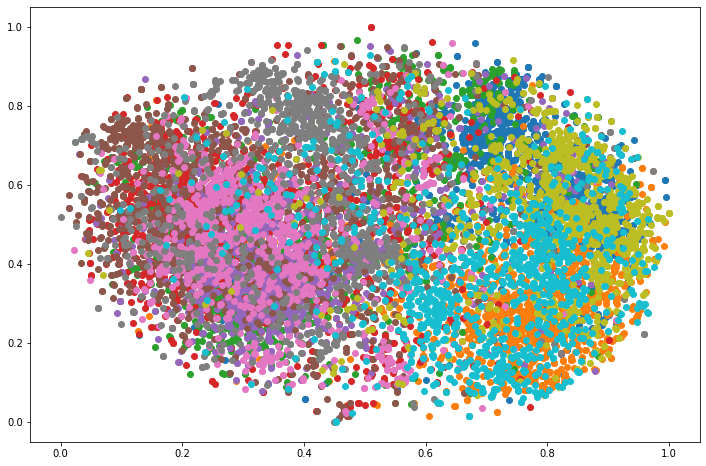

In [114]:
plt.rcParams['figure.figsize'] = [12,8]
width = 4000
height = 3000
max_dim = 100

for i in range(10):
    indices = np.where(targets == i)
    plt.scatter(tx[indices], ty[indices], label = str(i))

plt.show()



In [ ]:
full_image.save("embeddings.png")